In [1]:
import os
import glob
import pkbar
from typing import Tuple, List, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

import attn_dl
import attn_model
import scoring

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Model Training

In [31]:
def ou_loss(output, target):
    loss = 0
    i = 0
    while i < len(output) - 1:
        loss += abs(target[i] + target[i+1] - output[i] - output[i+1])
        i += 2
    return loss/(len(output)/2.)

In [32]:
ou_loss(torch.Tensor([1,2,3,4]), [5,6,7,8])

tensor(8.)

In [33]:
# Roughly follows https://pytorch.org/tutorials/beginner/nn_tutorial.html#

# Model hyperparameters
num_epochs = 50
batch_size = 128
learning_rate = 0.0001
heads = 5
depth = 2
pbar = pkbar.Pbar(name='Training Model', target = num_epochs)

# Load data as torch.tensors
_, x_train, y_train = attn_dl.load_vectorized_data('train')
_, x_validate, y_validate = attn_dl.load_vectorized_data('dev')

model = attn_model.TransformerModel(x_train.shape[2], heads, depth).double()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_ds = TensorDataset(x_train, y_train)
# Notice we shuffle our training data so the seasons are mixed!
train_dl = DataLoader(train_ds, batch_size=batch_size, 
                      shuffle=True)

validate_ds = TensorDataset(x_validate, y_validate)
validate_dl = DataLoader(validate_ds, 
                         batch_size=batch_size * 2)

# L1 loss is more robust to outliers
loss_func = ou_loss

losses = []
for epoch in range(num_epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred.double(), yb.double())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        epoch_loss = sum(loss_func(model(xb), yb) for xb, yb in validate_dl)
        if epoch % 10 == 0:
            print(epoch_loss/len(xb))
        losses.append( epoch_loss / len(xb) )
    pbar.update(epoch)

Training Model
tensor([17.8277], dtype=torch.float64)
50/50  [==============================] - 112.5s


In [34]:
# Training error
train_diff = loss_func(model(x_train), y_train).detach()
train_diff

tensor([16.0132], dtype=torch.float64)

## Validation Performance

In [35]:
# Total Loss on Validation Set
total_diff = loss_func(model(x_validate), y_validate).detach()
total_diff

tensor([20.1418], dtype=torch.float64)

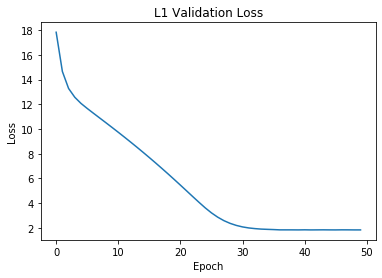

In [36]:
plt.title('L1 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

## Test Performance 

In [37]:
# Error on test set
i_test, x_test, y_test = attn_dl.load_vectorized_data('test')
y_predicted = model(x_test)
loss_func(y_predicted, y_test)

tensor([20.8493], dtype=torch.float64, grad_fn=<DivBackward0>)

## Model Evaluation

In [38]:
# OVER/UNDER results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 60, 2):
    won, lost, pushed = scoring.score(model, 'over/under', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 462  534    0 0.464 0.000
	 2 442  498   56 0.470 0.056
	 4 420  469  107 0.472 0.107
	 6 397  444  155 0.472 0.156
	 8 367  413  216 0.471 0.217
	10 334  371  291 0.474 0.292
	12 298  331  367 0.474 0.368
	14 262  283  451 0.481 0.453
	16 213  234  549 0.477 0.551
	18 182  189  625 0.491 0.628
	20 143  147  706 0.493 0.709
	22 116  110  770 0.513 0.773
	24  91   74  831 0.552 0.834
	26  59   51  886 0.536 0.890
	28  41   32  923 0.562 0.927
	30  26   23  947 0.531 0.951
	32  22   13  961 0.629 0.965
	34  12    7  977 0.632 0.981
	36   8    1  987 0.889 0.991
	38   3    1  992 0.750 0.996
	40   3    0  993 1.000 0.997
	42   2    0  994 1.000 0.998
	44   0    0  996 0.000 1.000
	46   0    0  996 0.000 1.000
	48   0    0  996 0.000 1.000
	50   0    0  996 0.000 1.000
	52   0    0  996 0.000 1.000
	54   0    0  996 0.000 1.000
	56   0    0  996 0.000 1.000
	58   0    0  996 0.000 1.000


In [11]:
# OVER/UNDER results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print('\t' + '-' * len(header))
for b in range(0, 50, 2):
    won, lost, pushed = scoring.score(model, 'over/under', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 480  516    0 0.482 0.000
	 2 457  493   46 0.481 0.046
	 4 430  461  105 0.483 0.105
	 6 403  435  158 0.481 0.159
	 8 378  403  215 0.484 0.216
	10 339  363  294 0.483 0.295
	12 289  322  385 0.473 0.387
	14 253  273  470 0.481 0.472
	16 217  225  554 0.491 0.556
	18 183  182  631 0.501 0.634
	20 141  140  715 0.502 0.718
	22 109  107  780 0.505 0.783
	24  77   69  850 0.527 0.853
	26  54   42  900 0.562 0.904
	28  38   22  936 0.633 0.940
	30  28   13  955 0.683 0.959
	32  14    7  975 0.667 0.979
	34  11    3  982 0.786 0.986
	36   9    1  986 0.900 0.990
	38   5    1  990 0.833 0.994
	40   2    0  994 1.000 0.998
	42   2    0  994 1.000 0.998
	44   2    0  994 1.000 0.998
	46   2    0  994 1.000 0.998
	48   2    0  994 1.000 0.998


In [12]:
# SPREAD results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 30, 2):
    won, lost, pushed = scoring.score(model, 'spread', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 482  514    0 0.484 0.000
	 2 421  447  128 0.485 0.129
	 4 316  339  341 0.482 0.342
	 6 228  235  533 0.492 0.535
	 8 134  138  724 0.493 0.727
	10  84   66  846 0.560 0.849
	12  42   35  919 0.545 0.923
	14  15   14  967 0.517 0.971
	16   2    3  991 0.400 0.995
	18   1    1  994 0.500 0.998
	20   0    0  996 0.000 1.000
	22   0    0  996 0.000 1.000
	24   0    0  996 0.000 1.000
	26   0    0  996 0.000 1.000
	28   0    0  996 0.000 1.000


In [452]:
# SPREAD results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 30, 2):
    won, lost, pushed = scoring.score(model, 'spread', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 486  510    0 0.488 0.000
	 2 391  418  187 0.483 0.188
	 4 300  299  397 0.501 0.399
	 6 214  187  595 0.534 0.597
	 8 133  118  745 0.530 0.748
	10  73   70  853 0.510 0.856
	12  35   39  922 0.473 0.926
	14  11    9  976 0.550 0.980
	16   4    2  990 0.667 0.994
	18   4    0  992 1.000 0.996
	20   2    0  994 1.000 0.998
	22   2    0  994 1.000 0.998
	24   2    0  994 1.000 0.998
	26   2    0  994 1.000 0.998
	28   2    0  994 1.000 0.998


## Open Questions

* Would directly predicting `spread` or `over/under` work better?
* Can attention layers help learn the interactions of different players on the court
* What other features would prove helpful?